In [1]:
import pandas as pd
# 使用efinance库
import efinance as ef
import numpy as np

from scipy.optimize import minimize

In [2]:

# 嘉实研究阿尔法：000082
# 易方达中债新综指：161119
# 标普500 ETF：513500
# 黄金 ETF：518880


# 获取数据
data_000082 = ef.fund.get_quote_history('000082')
data_161119 = ef.fund.get_quote_history('161119')
data_513500 = ef.fund.get_quote_history('513500')
data_518880 = ef.fund.get_quote_history('518880')

# 整理数据
data_000082 = data_000082[['日期', '单位净值']]
data_161119 = data_161119[['日期', '单位净值']]
data_513500 = data_513500[['日期', '单位净值']]
data_518880 = data_518880[['日期', '单位净值']]

# 合并数据
data = pd.merge(data_000082, data_161119, on='日期', suffixes=('_000082', '_161119'))
data = pd.merge(data, data_513500, on='日期')
data = pd.merge(data, data_518880, on='日期', suffixes=('_513500', '_518880'))

# 设置日期为索引并按日期排序
data['日期'] = pd.to_datetime(data['日期'])
data.set_index('日期', inplace=True)
data.sort_index(inplace=True)


In [3]:
data

,单位净值_000082,单位净值_161119,单位净值_513500,单位净值_518880
日期,,,,
2013-12-05,1.049,0.9852,1.0000,2.4320
2013-12-06,1.043,0.9848,1.0002,2.4310
2013-12-13,1.033,0.9843,1.0005,2.4180
2013-12-20,0.983,0.9814,1.0029,2.3610
2013-12-27,1.001,0.9823,1.0050,2.4020
...,...,...,...,...
2023-12-21,1.507,1.6274,1.5908,4.6005
2023-12-22,1.504,1.6289,1.5920,4.6306
2023-12-25,1.510,1.6302,1.5931,4.6336


In [4]:
# 计算资产收益率
returns = data.pct_change().dropna()

# 计算相关系数矩阵
correlation_matrix = returns.iloc[-250:].corr()

In [5]:
returns.iloc[-250:]

,单位净值_000082,单位净值_161119,单位净值_513500,单位净值_518880
日期,,,,
2022-12-20,-0.013341,0.000257,0.002621,-0.000025
2022-12-21,-0.000588,-0.000129,0.011962,0.010272
2022-12-22,-0.003529,0.000707,-0.013621,-0.000075
2022-12-23,-0.004132,0.001092,0.007143,-0.002335
2022-12-26,0.013041,0.000193,0.000158,-0.003649
...,...,...,...,...
2023-12-21,0.006008,0.000676,0.010930,-0.002212
2023-12-22,-0.001991,0.000922,0.000754,0.006543
2023-12-25,0.003989,0.000798,0.000691,0.000648


In [6]:
correlation_matrix

,单位净值_000082,单位净值_161119,单位净值_513500,单位净值_518880
单位净值_000082,1.000000,-0.183033,0.121102,-0.046116
单位净值_161119,-0.183033,1.000000,0.075869,0.022223
单位净值_513500,0.121102,0.075869,1.000000,-0.074764
单位净值_518880,-0.046116,0.022223,-0.074764,1.000000


In [22]:
# V = np.matrix('123 37.5 70 30; 37.5 122 72 13.5; 70 72 321 -32; 30 13.5 -32 52') / 100
# print(V)

[[ 1.23   0.375  0.7    0.3  ]
 [ 0.375  1.22   0.72   0.135]
 [ 0.7    0.72   3.21  -0.32 ]
 [ 0.3    0.135 -0.32   0.52 ]]


In [7]:
np.matrix(correlation_matrix)

matrix([[ 1.        , -0.18303324,  0.12110215, -0.0461157 ],
        [-0.18303324,  1.        ,  0.07586865,  0.02222337],
        [ 0.12110215,  0.07586865,  1.        , -0.07476373],
        [-0.0461157 ,  0.02222337, -0.07476373,  1.        ]])

In [8]:
V = np.matrix(correlation_matrix)

# 风险预算优化
def calculate_portfolio_var(w,V):
    # 计算组合风险的函数
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # 计算单个资产对总体风险贡献度的函数
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # 边际风险贡献
    MRC = V*w.T
    # 风险贡献
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # 计算组合风险
    V = pars[0]# 协方差矩阵
    x_t = pars[1] # 组合中资产预期风险贡献度的目标向量
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x



# 根据资产预期目标风险贡献度来计算各资产的权重
def calcu_w(x):
    w0 = [0.2, 0.2, 0.2, 0.6] 
#     x_t = [0.25, 0.25, 0.25, 0.25] # 目标是让四个资产风险贡献度相等，即都为25%
    x_t = x 
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})
    w_rb = np.asmatrix(res.x)
    return w_rb


# 将各资产风险贡献度绘制成柱状图
def plot_rc(w):
    rc = calculate_risk_contribution(w, V)
    rc = rc.tolist()
    rc = [i[0] for i in rc]
    rc = pd.DataFrame(rc,columns=['rick contribution'],index=[1,2,3,4])
    # T.plot(rc, chart_type='column', title = 'Contribution to risk')
    

# 假设四个资产的风险贡献度相等
w_rb = calcu_w([0.25, 0.25, 0.25, 0.25])
print('各资产权重：', w_rb)
plot_rc(w_rb)


# 假设风险贡献度依次为0.3,0.3,0.1,0.3
w = calcu_w([0.3, 0.3 ,0.1,0.3])
print('各资产权重：', w)
plot_rc(w)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2295202793262113e-09
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10
各资产权重： [[0.25973208 0.25624296 0.2283574  0.25566756]]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.733659319164107e-08
            Iterations: 12
            Function evaluations: 64
            Gradient evaluations: 12
各资产权重： [[0.29473945 0.288734   0.13835706 0.27816948]]


In [3]:
# 完整代码
import pandas as pd
import efinance as ef
import numpy as np

from scipy.optimize import minimize


# 嘉实研究阿尔法：000082
# 易方达中债新综指：161119
# 标普500 ETF：513500
# 黄金 ETF：518880


# 获取数据
data_000082 = ef.fund.get_quote_history('000082')
data_161119 = ef.fund.get_quote_history('161119')
data_513500 = ef.fund.get_quote_history('513500')
data_518880 = ef.fund.get_quote_history('518880')

# 整理数据
data_000082 = data_000082[['日期', '单位净值']]
data_161119 = data_161119[['日期', '单位净值']]
data_513500 = data_513500[['日期', '单位净值']]
data_518880 = data_518880[['日期', '单位净值']]

# 合并数据
data = pd.merge(data_000082, data_161119, on='日期', suffixes=('_000082', '_161119'))
data = pd.merge(data, data_513500, on='日期')
data = pd.merge(data, data_518880, on='日期', suffixes=('_513500', '_518880'))

# 设置日期为索引并按日期排序
data['日期'] = pd.to_datetime(data['日期'])
data.set_index('日期', inplace=True)
data.sort_index(inplace=True)


# 计算资产收益率
returns = data.pct_change().dropna()


# 计算相关系数矩阵
correlation_matrix = returns.cov()


V = np.matrix(correlation_matrix)

print(V)


# 风险预算优化
def calculate_portfolio_var(w,V):
    # 计算组合风险的函数
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # 计算单个资产对总体风险贡献度的函数
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # 边际风险贡献
    MRC = V*w.T
    # 风险贡献
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # 计算组合风险
    V = pars[0]# 协方差矩阵
    x_t = pars[1] # 组合中资产预期风险贡献度的目标向量
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x



# 根据资产预期目标风险贡献度来计算各资产的权重
def calcu_w(x, V):
    # w0 = [0.08, 0.73, 0.07, 0.12]
    w0 = [0.2, 0.2, 0.2, 0.6]
    x_t = x 
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(risk_budget_objective, w0, args=[V, x_t], method='SLSQP',constraints=cons, options={'disp': True})
    w_rb = np.asmatrix(res.x)
    return w_rb


# 假设四个资产的风险贡献度相等
w_rb = calcu_w([0.25, 0.25, 0.25, 0.25], V)
print('各资产权重：', w_rb)
# 结果样例：各资产权重： [[0.27228728 0.24917944 0.24198426 0.23654902]]


[[ 2.47517857e-04 -9.44158893e-07  2.41824867e-05 -8.51895703e-07]
 [-9.44158893e-07  7.63594230e-07 -1.16214734e-07  7.94850372e-07]
 [ 2.41824867e-05 -1.16214734e-07  2.33981384e-04  5.49412445e-07]
 [-8.51895703e-07  7.94850372e-07  5.49412445e-07  6.43735894e-05]]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.487791672815986e-06
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
各资产权重： [[0.1500161  0.14999949 0.15001662 0.54996779]]


In [ ]:
# 20231228
# [[ 2.53667605e-04 -9.82438883e-07  2.49130030e-05 -6.23146377e-07]
#  [-9.82438883e-07  7.83692877e-07 -1.46165060e-07  8.43127961e-07]
#  [ 2.49130030e-05 -1.46165060e-07  2.40288891e-04  6.49914953e-07]
#  [-6.23146377e-07  8.43127961e-07  6.49914953e-07  6.52066998e-05]]
# Optimization terminated successfully    (Exit mode 0)
#             Current function value: 6.5263033135613306e-06
#             Iterations: 1
#             Function evaluations: 6
#             Gradient evaluations: 1
# 各资产权重： [[0.150016   0.14999958 0.15001662 0.54996781]]

# 最初：1541  2021.5 1332.6 2104.18 = 7000
# 20231228: 1471.5 2047.45 1433.88 2196.51 = 7149.34



# 20240128
# [[ 2.48606510e-04 -9.50738638e-07  2.43940570e-05 -8.78408692e-07]
#  [-9.50738638e-07  7.69787202e-07 -1.21931871e-07  8.07270494e-07]
#  [ 2.43940570e-05 -1.21931871e-07  2.35905154e-04  5.27802823e-07]
#  [-8.78408692e-07  8.07270494e-07  5.27802823e-07  6.47679364e-05]]
# Optimization terminated successfully    (Exit mode 0)
#             Current function value: 6.525236751132612e-06
#             Iterations: 1
#             Function evaluations: 6
#             Gradient evaluations: 1
# 各资产权重： [[0.15001624 0.14999949 0.15001667 0.5499676 ]]


In [37]:
data

,单位净值_000082,单位净值_161119,单位净值_513500,单位净值_518880
日期,,,,
2013-12-05,1.049,0.9852,1.0000,2.4320
2013-12-06,1.043,0.9848,1.0002,2.4310
2013-12-13,1.033,0.9843,1.0005,2.4180
2013-12-20,0.983,0.9814,1.0029,2.3610
2013-12-27,1.001,0.9823,1.0050,2.4020
...,...,...,...,...
2023-09-22,1.650,1.6127,1.4611,4.5690
2023-09-25,1.642,1.6121,1.4668,4.6073
2023-09-26,1.639,1.6113,1.4453,4.5910


In [38]:
returns

,单位净值_000082,单位净值_161119,单位净值_513500,单位净值_518880
日期,,,,
2013-12-06,-0.005720,-0.000406,0.000200,-0.000411
2013-12-13,-0.009588,-0.000508,0.000300,-0.005348
2013-12-20,-0.048403,-0.002946,0.002399,-0.023573
2013-12-27,0.018311,0.000917,0.002094,0.017366
2013-12-31,0.009990,-0.000102,0.000995,-0.016653
...,...,...,...,...
2023-09-22,0.015385,-0.000186,-0.002322,-0.002402
2023-09-25,-0.004848,-0.000372,0.003901,0.008383
2023-09-26,-0.001827,-0.000496,-0.014658,-0.003538


In [34]:
V

matrix([[ 1.        , -0.08412532,  0.01399309, -0.02383056],
        [-0.08412532,  1.        ,  0.02222493,  0.0664346 ],
        [ 0.01399309,  0.02222493,  1.        ,  0.0107158 ],
        [-0.02383056,  0.0664346 ,  0.0107158 ,  1.        ]])

In [35]:
np.matrix('123 37.5 70 30; 37.5 122 72 13.5; 70 72 321 -32; 30 13.5 -32 52') / 100 

matrix([[ 1.23 ,  0.375,  0.7  ,  0.3  ],
        [ 0.375,  1.22 ,  0.72 ,  0.135],
        [ 0.7  ,  0.72 ,  3.21 , -0.32 ],
        [ 0.3  ,  0.135, -0.32 ,  0.52 ]])

In [41]:
assetReturns = returns.mean() # 算出每个股票的历史平均收益率
assetCovariance = returns.cov()  # 算出10个股票之间的协方差矩阵
assetCorrelations = returns.corr()  # 算出10个股票之间的相关系
# numAsset=len(names)
assetReturns * 250  # 年化收益率
assetCovariance*252  # 年化协方差矩阵

,单位净值_000082,单位净值_161119,单位净值_513500,单位净值_518880
单位净值_000082,0.063950,-0.000247,0.006284,-0.000166
单位净值_161119,-0.000247,0.000198,-0.000037,0.000214
单位净值_513500,0.006284,-0.000037,0.060572,0.000182
单位净值_518880,-0.000166,0.000214,0.000182,0.016393


In [44]:
returns.corr()

,单位净值_000082,单位净值_161119,单位净值_513500,单位净值_518880
单位净值_000082,1.000000,-0.069620,0.100971,-0.005131
单位净值_161119,-0.069620,1.000000,-0.010786,0.118786
单位净值_513500,0.100971,-0.010786,1.000000,0.005770
单位净值_518880,-0.005131,0.118786,0.005770,1.000000


In [ ]:
# 回测
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# 获取数据(使用您提供的数据)

# 整理数据(使用您提供的数据处理代码) 

# 计算相关系数矩阵(使用您提供的代码)

# 风险预算优化函数(使用您提供的代码)

# 计算权重函数(使用您提供的代码)

# 设置回测时间区间
start_date = '2018-01-01' 
end_date = '2022-12-31'

# 初始化账户,设置初始资金量为 10000
account = 10000 

# 遍历时间区间 
daily_returns = []

daily_weights = []

for i in range(len(data.loc[start_date:end_date])):
    # 提取当日收益率
    returns = data.loc[start_date:end_date].iloc[i-250:i][['单位净值_000082', '单位净值_161119', '单位净值_513500', '单位净值_518880']].pct_change().dropna()

    # 计算相关系数矩阵
    correlation_matrix = returns.cov()


    V = np.matrix(correlation_matrix)

    # 计算权重
    w_rb = calcu_w([0.25, 0.25, 0.25, 0.25], V)
    daily_weights.append((i, w_rb))

    
    # 计算当日收益率
    # daily_return = np.dot(returns, w_rb.T)

    # print(daily_return)

    # # 更新账户
    # account = account * (1 + daily_return)

    # # 赋值到Series
    # daily_returns.append(daily_return)

# 生成DataFrame
# df_returns = pd.DataFrame(daily_returns, columns=['daily_returns'])


In [68]:
print(daily_weights)

[(0, matrix([[0.2, 0.2, 0.2, 0.6]])), (1, matrix([[0.2, 0.2, 0.2, 0.6]])), (2, matrix([[0.2, 0.2, 0.2, 0.6]])), (3, matrix([[0.2, 0.2, 0.2, 0.6]])), (4, matrix([[0.2, 0.2, 0.2, 0.6]])), (5, matrix([[0.2, 0.2, 0.2, 0.6]])), (6, matrix([[0.2, 0.2, 0.2, 0.6]])), (7, matrix([[0.2, 0.2, 0.2, 0.6]])), (8, matrix([[0.2, 0.2, 0.2, 0.6]])), (9, matrix([[0.2, 0.2, 0.2, 0.6]])), (10, matrix([[0.2, 0.2, 0.2, 0.6]])), (11, matrix([[0.2, 0.2, 0.2, 0.6]])), (12, matrix([[0.2, 0.2, 0.2, 0.6]])), (13, matrix([[0.2, 0.2, 0.2, 0.6]])), (14, matrix([[0.2, 0.2, 0.2, 0.6]])), (15, matrix([[0.2, 0.2, 0.2, 0.6]])), (16, matrix([[0.2, 0.2, 0.2, 0.6]])), (17, matrix([[0.2, 0.2, 0.2, 0.6]])), (18, matrix([[0.2, 0.2, 0.2, 0.6]])), (19, matrix([[0.2, 0.2, 0.2, 0.6]])), (20, matrix([[0.2, 0.2, 0.2, 0.6]])), (21, matrix([[0.2, 0.2, 0.2, 0.6]])), (22, matrix([[0.2, 0.2, 0.2, 0.6]])), (23, matrix([[0.2, 0.2, 0.2, 0.6]])), (24, matrix([[0.2, 0.2, 0.2, 0.6]])), (25, matrix([[0.2, 0.2, 0.2, 0.6]])), (26, matrix([[0.2, 0.

In [11]:
# 计算按照给定比例持有四种资产的组合收益率
weights = [0.150016, 0.14999958, 0.15001662, 0.54996781]
portfolio_returns = (data.pct_change() * weights).sum(axis=1)

print(portfolio_returns)

日期
2013-12-05    0.000000
2013-12-06   -0.001115
2013-12-13   -0.004410
2013-12-20   -0.020308
2013-12-27    0.012749
                ...   
2023-12-21    0.001426
2023-12-22    0.003551
2023-12-25    0.001178
2023-12-26    0.001360
2023-12-27    0.003164
Length: 2352, dtype: float64


<Axes: xlabel='日期'>

/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  func(*args, **kwargs)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


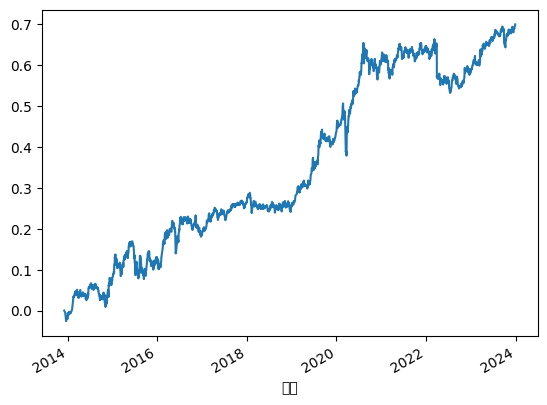

In [18]:
(data.pct_change() * weights).sum(axis=1).cumsum().plot()

In [ ]:
import matplotlib.pyplot as plt

# 绘制收益率曲线
plt.plot(portfolio_returns.index, portfolio_returns)
plt.xlabel('日期')
plt.ylabel('收益率')
plt.title('资产组合收益率曲线')
plt.xticks(rotation=45)
plt.show()

In [10]:
# import pandas as pd
# import efinance as ef
# import numpy as np
# from scipy.optimize import minimize

# # 可配置参数
# ASSET_LIST = ['000082', '161119', '513500', '518880']
# ASSET_NAMES = ['嘉实研究阿尔法', '易方达中债新综指', '标普500 ETF', '黄金 ETF']
# START_WEIGHTS = [0.2, 0.2, 0.2, 0.6] # 默认起始权重

# # 获取数据并处理
# def get_data(assets):
#     data_frames = []
#     for code in assets:
#         data = ef.fund.get_quote_history(code)[['日期', '单位净值']]
#         data.columns = ['日期', code]
#         data.set_index('日期', inplace=True)
#         data.sort_index(inplace=True)
#         data_frames.append(data)
#     df_merged = pd.concat(data_frames, axis=1, join='inner')
#     df_merged.index = pd.to_datetime(df_merged.index)
#     print(df_merged.head())
#     return df_merged

# # 根据传入的DataFrame计算收益率和协方差矩阵
# def calculate_cov_matrix(df):
#     returns = df.pct_change().dropna()
#     return returns.cov()


# # 组合风险函数
# def calculate_portfolio_var(w, V):
#     w = np.matrix(w)
#     return (w * V * w.T)[0, 0]

# # 单个资产风险贡献度函数
# def calculate_risk_contribution(w, V):
#     w = np.matrix(w)
#     sigma = np.sqrt(calculate_portfolio_var(w, V))
#     MRC = V * w.T
#     return np.multiply(MRC, w.T) / sigma

# # 风险预算目标函数
# def risk_budget_objective(x, pars):
#     V = pars[0]
#     x_t = pars[1]
#     sigma_p = np.sqrt(calculate_portfolio_var(x, V))
#     risk_target = np.asmatrix(np.multiply(sigma_p, x_t))
#     asset_RC = calculate_risk_contribution(x, V)
#     return sum(np.square(asset_RC - risk_target.T))[0, 0]

# # 约束条件
# def total_weight_constraint(x):
#     return np.sum(x) - 1.0

# def long_only_constraint(x):
#     return x

# # 主程序
# def main(dt):
#     # 获取数据
#     df_assets = get_data(ASSET_LIST)
#     df_sub = df_assets[df_assets.index <= pd.to_datetime(dt)]
#     V = calculate_cov_matrix(df_sub)
#     V_array = V.values # 转换为numpy数组
    
#     # 定义优化的约束
#     constraints = [
#         {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, # 投资组合权重总和为1
#         {'type': 'ineq', 'fun': lambda x: x} # 长仓约束
#     ]

#     # 风险预算优化
#     opt_result = minimize(
#         risk_budget_objective,
#         START_WEIGHTS,
#         args=[V_array, START_WEIGHTS],
#         method='SLSQP',
#         constraints=constraints
#     )
    
#     return opt_result.x if opt_result.success else None

# # 调用主函数
# dt = '2024-01-29'  # 给定日期
# weights = main(dt)
# if weights is not None:
#     weights_dict = dict(zip(ASSET_NAMES, weights))
#     print('各资产权重：', weights_dict)
# else:
#     print('优化没有成功，请检查输入数据和约束条件')

            000082  161119  513500  518880
日期                                        
2013-12-05   1.049  0.9852  1.0000   2.432
2013-12-06   1.043  0.9848  1.0002   2.431
2013-12-13   1.033  0.9843  1.0005   2.418
2013-12-20   0.983  0.9814  1.0029   2.361
2013-12-27   1.001  0.9823  1.0050   2.402
各资产权重： {'嘉实研究阿尔法': 0.14998863726226966, '易方达中债新综指': 0.15000795015579765, '标普500 ETF': 0.14999095424043812, '黄金 ETF': 0.5500124583414944}


In [ ]:
# import pandas as pd
# import efinance as ef
# import numpy as np
# from scipy.optimize import minimize

# # 可配置参数
# ASSET_LIST = ['000082', '161119', '513500', '518880']
# ASSET_NAMES = ['嘉实研究阿尔法', '易方达中债新综指', '标普500 ETF', '黄金 ETF']

# # 获取数据并处理
# def get_data(assets):
#     data_frames = []
#     for code in assets:
#         data = ef.fund.get_quote_history(code)[['日期', '单位净值']]
#         data.columns = ['日期', code]
#         data.set_index('日期', inplace=True)
#         data.sort_index(inplace=True)
#         data_frames.append(data)
#     df_merged = pd.concat(data_frames, axis=1, join='inner')
#     df_merged.index = pd.to_datetime(df_merged.index)
#     return df_merged


# from sklearn.covariance import EmpiricalCovariance
# from sklearn.datasets import make_gaussian_quantiles


# def calculate_cov_matrix(df):
#     """计算协方差矩阵"""
#     # print(df)
#     df = df / df.iloc[0] * 100 # 统一缩放到100为基点
#     returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
#     # returns_df = np.log(df/df.shift(1)) # 对数收益率
#     returns_df.dropna(axis='index', inplace=True) # 删除空数据
#     one_cov_matrix = returns_df.cov()*240
#     return np.matrix(one_cov_matrix)


# def get_train_set(change_time, df):
#     """返回训练样本数据"""
#     # change_time: 调仓时间
#     df = df.loc[df.index<change_time] 
#     df = df.iloc[-240:] #每个调仓前240个交易日
#     return df 

# # 标准风险平价下的风险贡献
# def calculate_risk_contribution(weight,one_cov_matrix):
#     weight=np.matrix(weight) 
#     sigma=np.sqrt(weight*one_cov_matrix*weight.T)
#     # 边际风险贡献 Marginal Risk Contribution (MRC)
#     MRC=one_cov_matrix*weight.T/sigma
#     # 风险贡献 Risk Contribution (RC)
#     RC=np.multiply(MRC,weight.T)
#     return RC

# import scipy.optimize as sco
# import scipy.interpolate as sci

# # 定义优化问题的目标函数，即最小化资产之间的风险贡献差
# def naive_risk_parity(weight,parameters): 
#     # weight: 待求解的资产权重,
#     # parameters: 参数列表 
#     # parameters[0]: 协方差矩阵
#     # parameters[1]: 风险平价下的目标风险贡献度向量

#     one_cov_matrix=parameters[0]
#     RC_target_ratio=parameters[1] 
#     # RC_target为风险平价下的目标风险贡献，一旦参数传递以后，RC_target就是一个常数，不随迭代而改变
#     sigma_portfolio=np.sqrt(weight*one_cov_matrix*np.matrix(weight).T) # 组合波动率
#     RC_target=np.asmatrix(np.multiply(sigma_portfolio,RC_target_ratio))    # 目标风险贡献
#     # RC_real是 每次迭代以后最新的真实风险贡献，随迭代而改变
#     RC_real=calculate_risk_contribution(weight,one_cov_matrix)
#     sum_squared_error= sum(np.square(RC_real-RC_target.T))[0,0] 
#     return sum_squared_error 


# # 根据资产预期目标风险贡献度来计算各资产的权重
# def calculate_portfolio_weight(one_cov_matrix,risk_budget_objective):
#     '''
#     约束条件的类型只有'eq'和'ineq'两种
#     eq表示约束方程的返回结果为0
#     ineq表示约束方程的返回结果为非负数
#     '''
#     num = data.shape[1]
#     x0 = np.array([1.0 / num for _ in range(num)]) # 初始资产权重
#     bounds = tuple((0, 1) for _ in range(num))     # 取值范围(0,1)

#     cons_1 = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},)   #权重和为1
#     RC_set_ratio = np.array([1.0 / num for _ in range(num)])   #风险平价下每个资产的目标风险贡献度相等
#     optv = sco.minimize(risk_budget_objective, x0, args=[one_cov_matrix,RC_set_ratio], method='SLSQP', bounds=bounds, constraints=cons_1)
#     return optv.x


# def get_weight_matrix(df, method=None, half=False):
#     """返回资产权重矩阵"""
#     period_type = 'Q'
#     df_weight= df.resample(period_type).last()
#     df_weight = df_weight[df_weight.index>='2017-12-31']
            
#     for i in range(len(df_weight.index)):
#         change_time = df_weight.index[i]

#         train_set = get_train_set(change_time, df)

#         one_cov_matrix = calculate_cov_matrix(train_set)

#         df_weight.iloc[i] = calculate_portfolio_weight(one_cov_matrix,naive_risk_parity)
#         #backtest_set = get_backtest_set(change_time,next_change_time,df)    
#         #df_weight.iloc[i] = calculate_portfolio_weight(one_cov_matrix) 
#     return df_weight

In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import efinance as ef
import akshare as ak



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# # 可配置参数
ASSET_LIST = ['000082', '161119', '513500', '518880']
ASSET_NAMES = ['嘉实研究阿尔法', '易方达中债新综指', '标普500 ETF', '黄金 ETF']

# ASSET_LIST = ['159934', '159941', '510880']
# ASSET_NAMES = ['黄金ETF', '纳指ETF', '红利ETF']

# 获取数据并处理
def get_data(assets):
    data_frames = []
    for code in assets:
        data = ef.fund.get_quote_history(code)[['日期', '累计净值']]
        data.columns = ['日期', code]
        data.set_index('日期', inplace=True)
        data.sort_index(inplace=True)
        data_frames.append(data)
    df_merged = pd.concat(data_frames, axis=1, join='inner')
    df_merged.index = pd.to_datetime(df_merged.index)
    return df_merged

# 计算协方差矩阵
def calculate_cov_matrix(df):
    df = df / df.iloc[0] * 100
    returns_df = df.pct_change().dropna()
    one_cov_matrix = returns_df.cov() * 240
    return np.matrix(one_cov_matrix)

# 获取训练集
def get_train_set(change_time, df):
    df = df.loc[df.index < change_time]
    df = df.iloc[-240:] # 使用调仓日前240个交易日的数据
    return df 

# 计算风险贡献
def calculate_risk_contribution(weight, cov_matrix):
    weight = np.matrix(weight)
    portfolio_volatility = np.sqrt(weight * cov_matrix * weight.T)
    MRC = cov_matrix * weight.T / portfolio_volatility
    RC = np.multiply(MRC, weight.T)
    return RC

# 风险平价优化
def naive_risk_parity(weight, parameters):
    cov_matrix, target_rc_ratio = parameters
    portfolio_volatility = np.sqrt(weight * cov_matrix * np.matrix(weight).T)
    target_rc = np.asmatrix(np.multiply(portfolio_volatility, target_rc_ratio))
    actual_rc = calculate_risk_contribution(weight, cov_matrix)
    error = np.sum(np.square(actual_rc - target_rc.T))
    return error 

# 计算资产权重
def calculate_portfolio_weight(cov_matrix, objective):
    num_assets = len(ASSET_LIST)
    x0 = np.array([1.0 / num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
    # RC_target_ratio = np.array([1.0 / num_assets] * num_assets)
    RC_target_ratio = np.array([0.2, 0.2, 0.4, 0.2])
    options = {'ftol': 1e-20, 'maxiter': 2000}
    
    result = minimize(objective, x0, args=[cov_matrix, RC_target_ratio], method='SLSQP', 
                      bounds=bounds, constraints=constraints, options=options)
    return result.x


# 计算权重主函数
def get_weight_matrix(data, method='naive_risk_parity'):
    period_type = 'Q'
    df_weight = pd.DataFrame(index=data.index, columns=ASSET_LIST)
    df_weight= data.resample(period_type).last()
    df_weight = df_weight[df_weight.index>='2013-12-31']

    for change_time in df_weight.index:
        train_set = get_train_set(change_time, data)
        if train_set.empty:
            continue  # Skip if there's no data in the training set
        cov_matrix = calculate_cov_matrix(train_set)
        if isinstance(cov_matrix, np.matrix) and cov_matrix.size > 0:
            weights = calculate_portfolio_weight(cov_matrix, naive_risk_parity)
            df_weight.loc[change_time] = weights
    return df_weight

# 使用示例
data = get_data(ASSET_LIST)
weights_matrix = get_weight_matrix(data)
print(weights_matrix)

                  000082    161119    513500    518880
日期                                                    
2013-12-31  1.248303e-02  0.225768  0.743335  0.018414
2014-03-31  7.086944e-02  0.565942  0.281441  0.081748
2014-06-30  7.102547e-02  0.629593  0.210308  0.089074
2014-09-30  7.076972e-02  0.663274  0.179082  0.086874
2014-12-31  7.886131e-02  0.613695  0.207106  0.100338
2015-03-31  7.544775e-02  0.656004  0.171306  0.097242
2015-06-30  6.059740e-02  0.653669  0.179140  0.106594
2015-09-30  3.874482e-02  0.715885  0.140009  0.105361
2015-12-31  3.112514e-02  0.784221  0.100178  0.084476
2016-03-31  2.673561e-02  0.799065  0.091607  0.082593
2016-06-30  2.375681e-02  0.827477  0.078897  0.069869
2016-09-30  3.590302e-02  0.803098  0.092127  0.068872
2016-12-31  4.573940e-02  0.744641  0.125844  0.083775
2017-03-31  9.303493e-02  0.668309  0.150925  0.087730
2017-06-30  1.215105e-01  0.638747  0.154008  0.085735
2017-09-30  1.223382e-01  0.620675  0.163363  0.093623
2017-12-31

In [2]:
# # # #####


# def portfolio_variance(weights, cov_matrix):  # 定义投资组合方差函数
#     return np.dot(weights.T, np.dot(cov_matrix* 250, weights))  # 计算并返回投资组合方差

# # 优化投资组合的函数
# def optimize_portfolio(returns):  # 定义优化投资组合函数
#     # 计算协方差矩阵
#     print(returns)
#     cov_matrix = returns.cov()  # 计算收益的协方差矩阵
#     # 投资组合中的资产数量
#     num_assets = len(returns.columns)  # 计算投资组合中的资产数量
#     # 初始权重（平均分配）
#     init_weights = np.array([1/num_assets] * num_assets)  # 设置初始权重
#     # 约束条件
#     weight_sum_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}  # 权重和约束
#     bounds = [(0, 1) for _ in range(num_assets)]  # 权重范围约束
#     # 优化
#     result = minimize(portfolio_variance, init_weights, args=(cov_matrix), bounds=bounds, constraints=weight_sum_constraint)  
#     return result.x  # 返回优化结果


# # 计算权重主函数
# def get_weight_matrix(data, method='naive_risk_parity'):
#     period_type = 'M'
#     df_weight = pd.DataFrame(index=data.index, columns=ASSET_LIST)
#     df_weight= data.resample(period_type).last()
#     df_weight = df_weight[df_weight.index>='2013-12-31']

#     for change_time in df_weight.index:
#         train_set = get_train_set(change_time, data)
#         if train_set.empty:
#             continue  # Skip if there's no data in the training set

#         weights = optimize_portfolio(train_set)
#         df_weight.loc[change_time] = weights
#     return df_weight

# # 使用示例
# data = get_data(ASSET_LIST)
# weights_matrix = get_weight_matrix(data)
# print(weights_matrix)

# # ######

/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-6743}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.

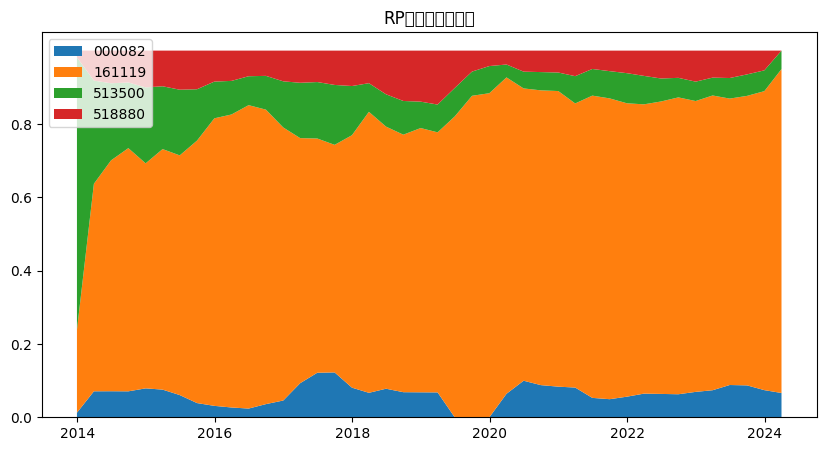

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.context('Solarize_Light2')
for i in range(weights_matrix.shape[0]):
    weights_matrix.iloc[i] = weights_matrix.iloc[i]/weights_matrix.iloc[i].sum()
labels = weights_matrix.columns.to_list()
fig, ax = plt.subplots(figsize=(10,5))
#variable_name = list(dict(df=df).keys())[0]
#variable_name = variable_name.split("_")[-1]
plt.title("RP模型权重分布图")
plt.yticks(np.arange(0, 1, step=0.2))
ax.stackplot(weights_matrix.index, weights_matrix.T,baseline='zero',labels=labels)
ax.legend(loc='upper left')
plt.show()

In [4]:
def get_backtest_set(change_time,next_change_time,df):
    """返回回测样本数据"""
    #change_time: 调仓时间
    #next_change_time: 下一次调仓时间
    df = df.loc[(change_time<=df.index)&(df.index<next_change_time)]
    return df 

def get_backtest(df_weight,df):
    change_time_list = df_weight.index.to_list()
    df_b = df.loc['2008-12-31':]
    #df_b = df.loc[(df.index>=change_time_list[0])]   #截取回测区间内的指数,即2018-12-31日开始
    df_b = df_b / df_b.iloc[0]*100     # 统一缩放到100为基点
    backtest = pd.DataFrame(columns=df.columns)  #创建一个空dataframe,用于插入回测数据    
    for i in range(len(change_time_list)-1):
        change_time = change_time_list[i]            #调仓日期
        next_change_time = change_time_list[i+1]     #下一个调仓日期
        #根据调仓时间乘以相应权重
        backtest_set = get_backtest_set(change_time,next_change_time,df_b)
        backtest_set = backtest_set / backtest_set.iloc[0]*100  # 统一缩放到100为基点
        if i == 0 :
            weight = df_weight.loc[change_time]
        else:
            weight = df_weight.loc[change_time]*backtest.iloc[-1].sum()/100
        backtest_set = backtest_set.multiply(weight)
        backtest = backtest.append(backtest_set)
    return backtest  


backtest = get_backtest(weights_matrix, data)  


In [5]:
plt.plot(backtest.sum(axis=1))

NameError: name 'plt' is not defined

In [6]:
def get_return_df(df):
    returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
    # returns_df = np.log(df/df.shift(1)) # 对数收益率
    returns_df.dropna(axis='index', inplace=True) # 删除空数据
    return returns_df

# 计算最大回撤
def max_draw_down(ret): 
    ret = np.array(ret)
    index_j = np.argmax(np.maximum.accumulate(ret) - ret)  # 结束位置
    index_i = np.argmax(ret[:index_j])  # 开始位置
    dd = ret[index_i] - ret[index_j]  # 最大回撤
    dd = dd/ret[index_i]
    return dd,index_i,index_j

def get_eval_indicator(ret):
    """各种评价指标"""
    eval_indicator = pd.Series(index=['累计收益率','年化收益率','年化波动率','最大回撤','sharpe比率','Calmar比率'])
    return_df = get_return_df(ret)
    #累计收益率
    eval_indicator['累计收益率'] = ret.iloc[-1]/ret.iloc[0] - 1
    #年华收益率  
    annual_ret = (ret.iloc[-1]/ret.iloc[0])**(240/ret.shape[0])-1
    eval_indicator['年化收益率'] = annual_ret
    #annual_ret = np.power(1+return_df.mean(), 250)-1 # 几何年化收益
    #年华波动率
    sigma = return_df.std() * (240**0.5)
    eval_indicator['年化波动率'] = sigma
    # 最大回撤
    dd, dd_index_start, dd_index_end = max_draw_down(ret)
    eval_indicator['最大回撤'] = dd
    #夏普比率  无风险利率是3%
    bench_annual_ret = 0.03
    sharpe = (annual_ret-bench_annual_ret)/sigma
    eval_indicator['sharpe比率'] = sharpe
    #Calmar比率=年化收益率/最大历史回撤
    calmar = annual_ret/dd
    eval_indicator['Calmar比率'] = calmar
    return eval_indicator

def get_eval_portfolio(backtest_res):
    """返回各个模型回测的评价结果"""
    eval_portfolio = pd.DataFrame(columns=backtest_res.columns)
    for name in eval_portfolio.columns:
        ret = backtest_res[name]
        eval_portfolio[name] = get_eval_indicator(ret)
    return eval_portfolio

In [7]:
r = {'RP': backtest.sum(axis=1)}
backtest_res = pd.DataFrame(r)
np.around(get_eval_portfolio(backtest_res)*100,2)

,RP
累计收益率,84.77
年化收益率,6.41
年化波动率,2.62
最大回撤,3.54
sharpe比率,130.24
Calmar比率,181.22


In [7]:
r = {'RP': backtest.sum(axis=1)}
backtest_res = pd.DataFrame(r)
np.around(get_eval_portfolio(backtest_res)*100,2)

,RP
累计收益率,112.06
年化收益率,9.09
年化波动率,8.56
最大回撤,14.56
sharpe比率,71.13
Calmar比率,62.42


In [37]:
#创建无风险资产序列，设定无风险资产的日收益率是1.25%%
non_risk_array = pd.Series(index=data.index)
rate = 1
i = 1
while i < len(non_risk_array):
    rate = rate*1.000125
    non_risk_array[i] = rate
    i = i +1 

df_ma = data.rolling(60).mean()   #60天移动平均线
df_ma = df_ma.groupby(data.index.to_period("M")).last()  #月末60天移动平均线
df_m = data.groupby(data.index.to_period("M")).last()     #月末交易日指数

#如果df_ma>df_m，则表明改资产应卖出
#如果df_ma>df_m,则为0，否则为1，此时df_ma变为趋势调整矩阵，这样与权重矩阵相乘，相应的权重就会变为0，
for i in df_ma.index.to_list():
    for j in df_ma.columns.to_list():
        if df_ma.loc[i,j] >= df_m.loc[i,j]:
            df_ma.loc[i,j] = 0
        else:
            df_ma.loc[i,j] = 1 

In [38]:
df_weight_pcrp = get_weight_matrix(data,method='pca')   # 获取权重矩阵，日期间隔为季度
df_weight_pcrp.index = df_weight_pcrp.index.to_period("M")    #改变权重矩阵的日期格式为月
monthly_weight = data.groupby(data.index.to_period("M")).last()   #创建日期间隔为月度的权重矩阵
#将df_weight_pcrp的权重插入到monthly_weight
for date in monthly_weight.index:                              
    if date in df_weight_pcrp.index:
        monthly_weight.loc[date] = df_weight_pcrp.loc[date]
    else:
        monthly_weight.loc[date] = np.nan
#补齐缺失值
monthly_weight.fillna(method='bfill',inplace=True)

In [39]:
monthly_weight = monthly_weight['2008-12-31':]
df_ma = df_ma['2008-12-31':]
non_risk_weight = 1-(monthly_weight*df_ma).sum(axis=1)   # 无风险资产权重
monthly_weight = monthly_weight*df_ma
monthly_weight['non_risk'] = non_risk_weight            #添加了无风险资产权重的权重矩阵
monthly_weight.index = monthly_weight.index.to_timestamp(how='end',freq='D')

In [41]:
df_plusnon = data.groupby(data.index.to_period("M")).last()
df_plusnon['non_risk'] = non_risk_array    # 添加了无风险资产的指数

In [43]:
def backtest_TF_PCRP(monthly_weight,df_plusnon):
    """TF-PCRP回测结果"""
    backtest = get_backtest(monthly_weight,df_plusnon)
    backtest_res['TF-PCRP'] = backtest.sum(axis=1)
    return backtest 

c = backtest_TF_PCRP(monthly_weight, df_plusnon)

TypeError: Invalid comparison between dtype=period[M] and Timestamp

In [33]:
np.around(get_eval_portfolio(backtest_res)*100,2)

ValueError: attempt to get argmax of an empty sequence

In [31]:
# fund_open_fund_info_em_df = ak.fund_open_fund_info_em(symbol="159941", indicator="累计净值走势")
# plt.plot(fund_open_fund_info_em_df['累计净值'])

In [ ]:

# def get_backtest_set(change_time,next_change_time,df):
#     """返回回测样本数据"""
#     #change_time: 调仓时间
#     #next_change_time: 下一次调仓时间
#     df = df.loc[(change_time<=df.index)&(df.index<next_change_time)]
#     return df 

# def get_backtest(df_weight, df, transaction_fee_ratio=0.0002):
#     change_time_list = df_weight.index.to_list()
#     df_b = df.loc[df.index >= change_time_list[0]]  # 截取回测区间内的数据
#     df_b = df_b / df_b.iloc[0] * 100  # 统一缩放到100为基点
#     backtest = pd.DataFrame(index=df_b.index, columns=df_b.columns)  # 创建一个空DataFrame，用于插入回测数据
    
#     cash = 100  # 初始现金(基点)
#     weights = df_weight.iloc[0]  # 初始权重

#     for i in range(len(change_time_list) - 1):
#         start = change_time_list[i]  # 起始调仓日期
#         end = change_time_list[i + 1]  # 结束调仓日期
#         period_data = df_b.loc[start:end]

#         # 如果不是第一段时间，计算调仓时的资产价值
#         if i > 0:
#             values = period_data.iloc[0] * weights  # 各资产价值
#             cash = values.sum()  # 重新计算总价值
            
#         new_weights = df_weight.loc[start]  # 新权重
#         target_values = cash * new_weights  # 目标资产价值
#         trades = target_values - values if i > 0 else target_values

#         # 减去手续费
#         fees = np.abs(trades) * transaction_fee_ratio
#         cash -= fees.sum()  # 更新现金
        
#         # 根据实际交易后资金调整权重
#         adjusted_values = target_values - fees
#         weights = adjusted_values / cash
        
#         # 计算回测期间的表现
#         period_returns = period_data.multiply(weights, axis=1)
#         backtest.loc[start:end] = period_returns
        
#     return backtest

In [8]:
import pandas as pd
import numpy as np
from itertools import combinations
import akshare as ak
from scipy.optimize import minimize

# 假定我们可以使用akshare的ak.fund_em_open_fund_info获取所有公募基金信息
all_funds_info = ak.fund_em_open_fund_info()
# 根据基金类型进行筛选
# 这里需要针对akshare返回的数据结构进行调整，以匹配列名称
equity_funds = all_funds_info[all_funds_info['类型'] == '股票型']
bond_funds = all_funds_info[all_funds_info['类型'] == '债券型']
overseas_funds = all_funds_info[all_funds_info['类型'] == '海外型']

# 这里简单选取每个类型的前5个基金进行组合
selected_funds = pd.concat([
    equity_funds.head(5),
    bond_funds.head(5),
    overseas_funds.head(5)
])

# 这段代码假定了一个可以获取基金日价格的函数get_fund_daily_price
def get_fund_daily_price(fund_code):
    # 这里需要替换成实际获取基金日价格的函数
    fund_data = ak.fund_em_open_fund_info(fund_code=fund_code)
    return fund_data['单位净值']

# 计算组合的年化收益和标准差，计算Sharpe Ratio
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# 获取基金价格数据，计算日收益率和协方差矩阵
fund_prices = {}
for fund_code in selected_funds['基金代码']:
    fund_prices[fund_code] = get_fund_daily_price(fund_code)

prices_df = pd.DataFrame(fund_prices)
returns = prices_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# 优化组合以获得最佳Sharpe Ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

risk_free_rate = 0.03 # 可以根据实际的无风险利率进行调整
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_port_sharpe['x']

# 打印各基金的最优权重
optimal_portfolio = pd.DataFrame({'基金代码': selected_funds['基金代码'], '权重': optimal_weights})
print("Optimal portfolio weights (Based on Sharpe Ratio):\n", optimal_portfolio)

# 以下是回测的示例步骤，你可以按照前面提供的backtest函数进行回测
# 以便验证找到的最优组合在历史数据上的表现

# 请根据上述代码的返回生成自己的回测结果，
# 这可能包括计算累积收益、绘制资本曲线图、计算最大回撤、年化收益和夏普比率等。

# 因为涉及到实际的数据获取，回测部分应该在本地Python环境中实现，并可能需要针对数据格式进行调整。

AttributeError: module 'akshare' has no attribute 'fund_em_open_fund_info'

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import efinance as ef
import akshare as ak
from itertools import combinations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 使用efinance获取基金净值函数
def get_fund_nav(code, start_date='20200101'):
    df = ef.stock.get_quote_history(code, beg=start_date)
    df['净值日期'] = pd.to_datetime(df['日期'])
    df.set_index('净值日期', inplace=True)
    df.sort_index(inplace=True)
    return df['收盘']

# 计算sharpe函数
def calculate_sharpe_ratio(returns, risk_free_rate=0.03):
    sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)
    return sharpe_ratio

# 获取需要的基金历史净值，并计算Sharpe Ratio
def get_sharpe_ratios(fund_codes, start_date='20200101'):
    sharpe_ratios = {}
    for fund_code in fund_codes:
        fund_nav = get_fund_nav(fund_code, start_date)
        returns = fund_nav.pct_change().dropna()
        sharpe_ratios[fund_code] = calculate_sharpe_ratio(returns)
    return sharpe_ratios

# 从akshare获取所有基金列表
fund_info = ak.fund_em_fund_name()
# 计算基金历史净值的Sharpe Ratio
fund_codes = fund_info['基金代码'].tolist()
sharpe_ratios = get_sharpe_ratios(fund_codes)
# 根据sharpe ratio排序，选择前20名进行投资组合
sorted_funds_by_sharpe = sorted(sharpe_ratios.items(), key=lambda item: item[1], reverse=True)
selected_funds = [fund[0] for fund in sorted_funds_by_sharpe[:20]]

# 组合优化代码，可以通过调整需求数量来改变组合优化的基金数量
num_funds_to_optimize = 5  # For example
possible_combinations = list(combinations(selected_funds, num_funds_to_optimize))
optimal_sharpe = 0
optimal_combination = None

def neg_sharpe(weights, returns, risk_free_rate):
    # Calculate the negative Sharpe Ratio
    portfolio_returns = np.dot(returns.mean(), weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return - (portfolio_returns - risk_free_rate) / portfolio_std_dev

for combination in possible_combinations:
    fund_data = {fund_code: get_fund_nav(fund_code) for fund_code in combination}
    fund_df = pd.DataFrame(fund_data).dropna()
    fund_returns = fund_df.pct_change().dropna()

    num_assets = len(combination)
    args = (fund_returns, 0.03)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(neg_sharpe, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if -result.fun > optimal_sharpe:
        optimal_sharpe = -result.fun
        optimal_combination = combination

print(f"Optimal Sharpe Ratio: {optimal_sharpe}")
print(f"Optimal Combination: {optimal_combination}")

/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/akshare/__init__.py:2676: UserWarning: 为了支持更多特性，请将 Pandas 升级到 2.1.0 及以上版本！
  warnings.warn(


AttributeError: module 'akshare' has no attribute 'fund_em_fund_name'